In [1]:
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
from IPython.display import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
lst_150 = glob.glob('F150LP/*/*flt.fits')
lst_165 = glob.glob('F165LP/*/*flt.fits')
lst_150

['F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cm_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cl_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cn_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457co_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ie_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403id_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ib_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ic_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gw_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gv_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gy_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gx_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xp_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xn_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xo_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xm_flt.fits',
 'F150LP/10/hst_16231_10_acs_sbc_f150lp_

In [3]:
def find_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    
    #print('X_center =', X_center)
    #print('Y_center =', Y_center)
    sky_coo_center = coo_pixtosky(r_center)
    #RA_center, DEC_center = sky_coo_center[0][0], sky_coo_center[1][0]
    return r_center, sky_coo_center


In [4]:
def avg_center(lst):
    a = np.array([[0.0],[0.0]])
    for item in lst:
        a += find_center(item)[1]
    return a/len(lst)

In [23]:
lst_150_nodc = []
for item in lst_150:
    file = fits.open(item)
    if file[1].header['MDECODT2'] < 25.0:
        lst_150_nodc.append(item)
lst_165_nodc = []
for item in lst_165:
    file = fits.open(item)
    if file[1].header['MDECODT2'] < 25.0:
        lst_165_nodc.append(item)
lst_165_nodc

['F165LP/57/hst_16231_57_acs_sbc_f165lp_jec457cp_flt.fits',
 'F165LP/03/hst_16231_03_acs_sbc_f165lp_jec403iu_flt.fits',
 'F165LP/03/hst_16231_03_acs_sbc_f165lp_jec403is_flt.fits',
 'F165LP/04/hst_16231_04_acs_sbc_f165lp_jec404gl_flt.fits',
 'F165LP/04/hst_16231_04_acs_sbc_f165lp_jec404gr_flt.fits',
 'F165LP/04/hst_16231_04_acs_sbc_f165lp_jec404go_flt.fits',
 'F165LP/04/hst_16231_04_acs_sbc_f165lp_jec404gi_flt.fits',
 'F165LP/56/hst_16231_56_acs_sbc_f165lp_jec456xj_flt.fits',
 'F165LP/56/hst_16231_56_acs_sbc_f165lp_jec456xk_flt.fits',
 'F165LP/56/hst_16231_56_acs_sbc_f165lp_jec456xl_flt.fits',
 'F165LP/56/hst_16231_56_acs_sbc_f165lp_jec456xi_flt.fits',
 'F165LP/10/hst_16231_10_acs_sbc_f165lp_jec410mj_flt.fits',
 'F165LP/10/hst_16231_10_acs_sbc_f165lp_jec410mk_flt.fits',
 'F165LP/10/hst_16231_10_acs_sbc_f165lp_jec410mi_flt.fits',
 'F165LP/10/hst_16231_10_acs_sbc_f165lp_jec410mh_flt.fits',
 'F165LP/08/hst_16231_08_acs_sbc_f165lp_jec408h8_flt.fits',
 'F165LP/08/hst_16231_08_acs_sbc_f165lp_

In [24]:
#avg_center_150= avg_center(lst_150)
#avg_center_165= avg_center(lst_165)
#print(avg_center_150)
#print(avg_center_165)
avg_center_all = avg_center(lst_150+lst_165)
avg_center_all

array([[3.19600330e+02],
       [2.91469478e-01]])

In [25]:
def new_CRVALs(inputfilename, ref_center):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    coo_center = find_center(inputfilename)
    r_center = coo_center[0]
    sky_coo_center = coo_center[1]
    
    new_CRVALs = ref_center - np.matmul(A, r_center - r0)
    return new_CRVALs

In [26]:
for item in lst_150_nodc:
    file = fits.open(item, mode = 'update')
    newname = file[0].header['ROOTNAME'][-5:]
    new_crvals = new_CRVALs(item, avg_center_all)
    for i in [1,2,3]:
        file[i].header['CRVAL1'] = new_crvals[0][0]
        file[i].header['CRVAL2'] = new_crvals[1][0]
    
    file.writeto(newname + '.fits', overwrite = True)

In [27]:
for item in lst_165_nodc:
    file = fits.open(item, mode = 'update')
    newname = file[0].header['ROOTNAME'][-5:]
    new_crvals = new_CRVALs(item, avg_center_all)
    for i in [1,2,3]:
        file[i].header['CRVAL1'] = new_crvals[0][0]
        file[i].header['CRVAL2'] = new_crvals[1][0]
    
    file.writeto(newname + '.fits', overwrite = True)

In [28]:
#lst_150_temp = []
#for item in lst_150:
#    lst_150_temp.append(item[42:46]+ 'q.fits')
#lst_165_temp = []
#for item in lst_165:
#    lst_165_temp.append(item[42:46]+ 'q.fits')

lst_150_nodc_temp = []
for item in lst_150_nodc:
    lst_150_nodc_temp.append(item[42:46] + 'q.fits')
lst_165_nodc_temp = []
for item in lst_165_nodc:
    lst_165_nodc_temp.append(item[42:46] + 'q.fits')

In [29]:
astrodrizzle.AstroDrizzle(lst_150_nodc_temp, 
                              output = 'F150LP_total_nodc2_test11', 
                              clean = True,
                              build = True,
                              context = True,
                              runfile = 'F150LP_total_nodc2_test11_drz.log',
                              num_cores = 1,
                              in_memory = False,
                              resetbits = 4096,
                              median = False,
                              static = False,
                              skysub = False,
                              driz_separate = False,
                              blot = False,
                              driz_cr = False,
                              final_bits = 0,
                              final_pixfrac = 0.6,
                              final_outnx=1947,
                              final_outny=1960, 
                              final_rot = 0.0,
                              final_scale = 0.025,
                              final_wcs = True)

Setting up logfile :  F150LP_total_nodc2_test11_drz.log
AstroDrizzle log file: F150LP_total_nodc2_test11_drz.log
AstroDrizzle Version 3.4.2 started at: 11:22:54.880 (14/06/2022)

==== Processing Step  Initialization  started at  11:22:54.88 (14/06/2022)

Preserving original of:  04gvq.fits as  OrIg_files/04gvq.fits
Preserving original of:  56xnq.fits as  OrIg_files/56xnq.fits
Preserving original of:  56xmq.fits as  OrIg_files/56xmq.fits
Preserving original of:  10mmq.fits as  OrIg_files/10mmq.fits
Preserving original of:  10mlq.fits as  OrIg_files/10mlq.fits
Preserving original of:  08i0q.fits as  OrIg_files/08i0q.fits
Preserving original of:  08i1q.fits as  OrIg_files/08i1q.fits
Preserving original of:  08i2q.fits as  OrIg_files/08i2q.fits
Preserving original of:  01nxq.fits as  OrIg_files/01nxq.fits
##############################################################################
#                                                                            #
# “minmed” is highly recommen

In [30]:
astrodrizzle.AstroDrizzle(lst_165_nodc_temp, 
                              output = 'F165LP_total_nodc2_test11', 
                              clean = True,
                              build = True,
                              context = True,
                              runfile = 'F165LP_total_nodc2_test11_drz.log',
                              num_cores = 1,
                              in_memory = False,
                              resetbits = 4096,
                              median = False,
                              static = False,
                              skysub = False,
                              driz_separate = False,
                              blot = False,
                              driz_cr = False,
                              final_bits = 0,
                              final_pixfrac = 0.6,
                              final_outnx=1947,
                              final_outny=1960, 
                              final_rot = 0.0,
                              final_scale = 0.025,
                              final_wcs = True)

Setting up logfile :  F165LP_total_nodc2_test11_drz.log
AstroDrizzle log file: F165LP_total_nodc2_test11_drz.log
AstroDrizzle Version 3.4.2 started at: 11:23:05.047 (14/06/2022)

==== Processing Step  Initialization  started at  11:23:05.04 (14/06/2022)

Preserving original of:  57cpq.fits as  OrIg_files/57cpq.fits
Preserving original of:  03iuq.fits as  OrIg_files/03iuq.fits
Preserving original of:  03isq.fits as  OrIg_files/03isq.fits
Preserving original of:  04grq.fits as  OrIg_files/04grq.fits
##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
#######################

In [54]:
final_150 = fits.open('F150LP_total_test10_drz.fits')
data_150 = final_150[1].data
final_165 = fits.open('F165LP_total_test10_drz.fits')
data_165 = final_165[1].data

In [55]:
coeff = 0.3
final_data = data_150 - coeff * data_165

In [56]:
final_150[1].data = final_data
file.writeto('subtracted3' + '.fits', overwrite = True)

In [62]:
raw = fits.open('jec401nxq_raw.fits')
raw[0].header

SIMPLE  =                    T / data conform to FITS standard                  
BITPIX  =                   16 / bits per data value                            
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / File may contain standard extensions           
NEXTEND =                    3 / Number of standard extensions                  
GROUPS  =                    F / image is in group format                       
DATE    = '2022-04-13'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'jec401nxq_raw.fits                     ' / name of file              
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'ACS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000

In [41]:
file = fits.open('F165LP/57/hst_16231_57_acs_sbc_f165lp_jec457cs_flt.fits')

In [42]:
data = file[1].data

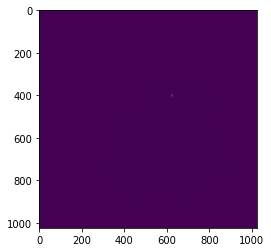

In [43]:
plt.imshow(data)